<a href="https://colab.research.google.com/github/SwayamParida/handwritten-math-exp-recognition/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import os
from collections import defaultdict
from PIL import Image
from skimage import feature
from sklearn import linear_model, model_selection, preprocessing
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, utils
from torchvision import datasets, models, transforms

plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline

## Atomic Symbol Dataset

The atomic symbol dataset is contained in the directory referenced by the relative filepath stored in `ATOMIC_SYMBOL_DATASET_DIR`. The dataset contains a subdirectory per math symbol with the directory name corresponding to the symbol name. Each subdirectory contains JPG images of the handwritten symbols that serve as training examples for that symbol class.

In [0]:
%cd drive/My\ Drive/cs231n/project/data
!cp symbol-data.zip /content/
%cd /content/
!unzip -nq symbol-data.zip

/content/drive/My Drive/cs231n/project/data
/content


In [0]:
ATOMIC_SYMBOL_DATASET_DIR = '/content/extracted_images'

In [0]:
symbol_dataset = datasets.ImageFolder(ATOMIC_SYMBOL_DATASET_DIR, 
                                      transform=transforms.ToTensor())

Getting a feel for the dataset

Symbol: pi
Image dimensions: (45, 45)


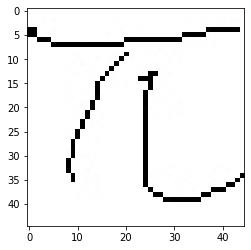

In [4]:
random_index = np.random.choice(len(symbol_dataset))
sample_img, sample_img_label = symbol_dataset[random_index]
sample_img = transforms.ToPILImage()(sample_img).convert(mode='L')
sample_img_label = symbol_dataset.classes[sample_img_label]
_ = plt.imshow(sample_img, cmap='Greys_r')
print(f'Symbol: {sample_img_label}')
print(f'Image dimensions: {sample_img.size}')

In [5]:
print(f'Number of examples: {len(symbol_dataset)}')
print(f'Number of classes: {len(symbol_dataset.classes)}')

Number of examples: 375974
Number of classes: 82


Distribution of labels in the dataset

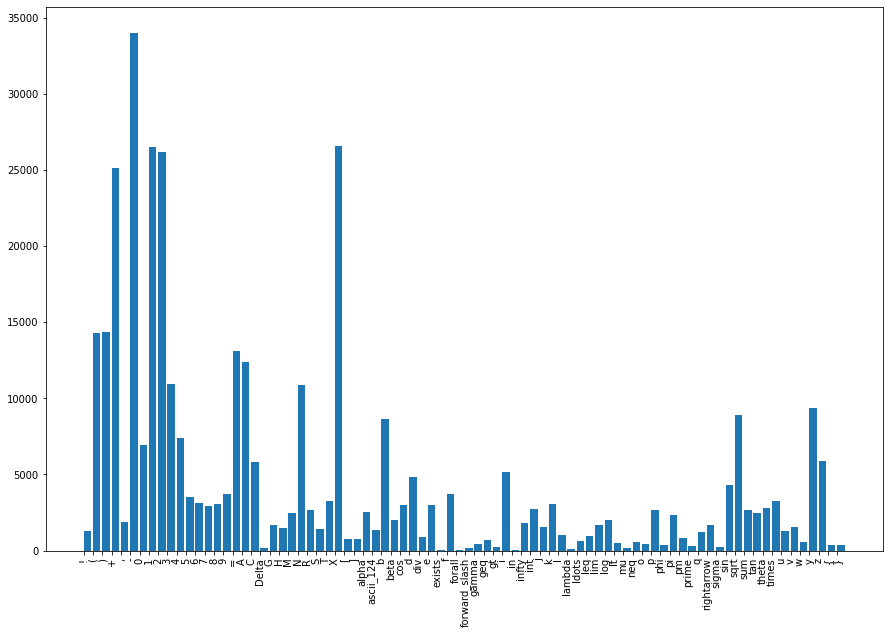

In [0]:
label_indices, label_counts = np.unique(symbol_dataset.targets, return_counts=True)
idx_to_class = {idx: label for (label, idx) in symbol_dataset.class_to_idx.items()}
plt.figure(figsize=[15, 10])
_ = plt.bar(np.arange(len(label_indices)), label_counts, align='edge',
            tick_label=[idx_to_class[idx] for idx in label_indices]
           )
_ = plt.xticks(rotation=90)

## CROHME 2014 Dataset


The CROHME 2014 Dataset for Task 2 consists of 310 x 310 images with entire expressions. These images shall be the inputs to our final model.

In [0]:
%cd drive/My\ Drive/cs231n/project/data
!cp exp-train-data-labels.zip /content/
!cp exp-train-data-imgs.zip /content/
!cp convertInkmlToImg.py /content
%cd /content/
!unzip -nq exp-train-data-labels.zip
!mv Train/ exp-train
!unzip -nq exp-train-data-imgs.zip
!python3 convertInkmlToImg.py Train/INKMLs/Train_2014/ 300 5 exp-train/IMGS/
%cd exp-train/IMGS
!mv data_png_Train_2014/* .
!rm -rf data_png_Train_2014
%cd ../LGs/
!mv Train2014_LG/train_LG_Obj/* .
!rm -rf Test2012_LG Test2013_LG Train2014_LG

In [0]:
class ExpressionDataset(utils.data.Dataset):
  def __init__(self, img_dir, label_dir):
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.imgs = [f.strip('.png') for f in os.listdir(self.img_dir) if '.png' in f]
    self.lgs = [f.strip('.lg') for f in os.listdir(self.label_dir) if '.lg' in f]
    # Take intersection of images and labels
    self.index = [(os.path.join(img_dir, f'{f}.png'), os.path.join(label_dir, f'{f}.lg'))
                  for f in set(self.imgs) & set(self.lgs)]

  def __len__(self):
    return len(self.index)

  def __getitem__(self, idx):
    if idx >= len(self.index):
      raise IndexError
    cur_img_fp, cur_label_fp = self.index[idx]
    cur_img = Image.open(cur_img_fp).convert('RGB')
    cur_label = self.lg_symbols(cur_label_fp)
    return cur_img, cur_label
  
  def transform(self, symbol):
      symbol = symbol.strip('\\')
      if symbol == 'COMMA': symbol = ','
      return symbol

  def lg_symbols(self, lg_file):
    with open(lg_file) as f:
      symbols = []
      for line in f:
        if line[0] == '#': continue
        if line[0] == '\n': break
        symbols += [self.transform(line.split(', ')[2])]
      return symbols

In [0]:
EXP_IMG_DIR = '/content/exp-train/IMGS'
EXP_LG_DIR = '/content/exp-train/LGs'

In [0]:
exp_dataset = ExpressionDataset(EXP_IMG_DIR, EXP_LG_DIR)

Getting a feel for the dataset

In [0]:
random_index = np.random.choice(len(exp_dataset))
sample_img, sample_img_symbols = exp_dataset[random_index]
_ = plt.imshow(sample_img, cmap='Greys_r')
print(f'Symbols: {sample_img_symbols}')
print(f'Image dimensions: {sample_img.size}')

In [0]:
print(f'Number of images in dataset: {len(exp_dataset)}')

# Baseline 1

To establish a baseline for the classification task, we shall develop a rudimentary model that segments each image of a mathematical expression into individual symbols deterministically by using rows and columns of entirely white pixels as the edges of a bounding. These segmented images (ideally) consisting of a single symbol are fed to a Softmax classifer that has been trained on the atomic symbols dataset for predictions.

Training a Softmax classifier on the raw pixels of the atomic symbols dataset

In [0]:
test_train_split = [0.8, 0.2]
assert(np.sum(test_train_split) == 1.0)

split_lengths = np.round(np.multiply(test_train_split, len(symbol_dataset)))
split_lengths = split_lengths.astype(int)
assert(np.sum(split_lengths) == len(symbol_dataset))

train_set, test_set = utils.data.random_split(symbol_dataset, split_lengths)
train_loader = utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
test_loader = utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=8)

In [0]:
model = linear_model.SGDClassifier(loss='log', alpha=1e-3, n_jobs=-1)

In [0]:
image_dims = symbol_dataset[0][0].size()
for i, (inputs, labels) in enumerate(train_loader):
    X = np.asarray(inputs).reshape((-1, np.prod(image_dims)))
    model.partial_fit(X, labels, classes=list(symbol_dataset.class_to_idx.values()))

    if i % 100 == 99: print(f'{i+1} batches seen.')

print('Finished Training')

100 batches seen.
200 batches seen.
300 batches seen.
400 batches seen.
500 batches seen.
600 batches seen.
700 batches seen.
800 batches seen.
900 batches seen.
1000 batches seen.
1100 batches seen.
1200 batches seen.
1300 batches seen.
1400 batches seen.
1500 batches seen.
1600 batches seen.
1700 batches seen.
1800 batches seen.
1900 batches seen.
2000 batches seen.
2100 batches seen.
2200 batches seen.
2300 batches seen.
Finished Training


Evaluating model

In [0]:
num_correct = 0
for (inputs, y_true) in test_loader:
  X = np.asarray(inputs).reshape((-1, np.prod(image_dims)))
  num_correct += np.sum(y_true.numpy() == model.predict(X))
print(f'Accuracy: {num_correct / len(test_loader)}')

Accuracy: 73.83673469387755


## Experiment 1

Performing image localization using YOLOv3 and image classification using AlexNet as feature extractor.

Using AlexNet as a feature extractor

In [11]:
model_ft = models.vgg11_bn(pretrained=True)

for param in model_ft.parameters():
  param.requires_grad = False
num_features = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_features, len(symbol_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

print(model_ft)

params_to_update = [param for param in model_ft.parameters() if param.requires_grad]
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)
loss_func = nn.CrossEntropyLoss()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Perform image transformations so that dataset images fit AlexNet configurations

In [0]:
tsfm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

symbol_dataset = datasets.ImageFolder(ATOMIC_SYMBOL_DATASET_DIR, transform=tsfm)

Splitting dataset into train and test sets

In [0]:
test_train_split = [0.8, 0.2]
assert(np.sum(test_train_split) == 1.0)

split_lengths = np.round(np.multiply(test_train_split, len(symbol_dataset)))
split_lengths = split_lengths.astype(int)
assert(np.sum(split_lengths) == len(symbol_dataset))

train_set, test_set = utils.data.random_split(symbol_dataset, split_lengths)
train_loader = utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=4)

Training a Softmax Layer with AlexNet features

In [14]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward + backward + optimize
        outputs = model_ft(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.922
[1,   200] loss: 1.188
[1,   300] loss: 1.050
[1,   400] loss: 0.970
[1,   500] loss: 0.901
[1,   600] loss: 0.888
[1,   700] loss: 0.861
[1,   800] loss: 0.834
[1,   900] loss: 0.816
[1,  1000] loss: 0.778
[1,  1100] loss: 0.778
[1,  1200] loss: 0.769
[1,  1300] loss: 0.788
[1,  1400] loss: 0.766
[1,  1500] loss: 0.760
[1,  1600] loss: 0.749
[1,  1700] loss: 0.763
[1,  1800] loss: 0.737
[1,  1900] loss: 0.730
[1,  2000] loss: 0.721
[1,  2100] loss: 0.748
[1,  2200] loss: 0.717
[1,  2300] loss: 0.710
[2,   100] loss: 0.702
[2,   200] loss: 0.697
[2,   300] loss: 0.708
[2,   400] loss: 0.692
[2,   500] loss: 0.695
[2,   600] loss: 0.701
[2,   700] loss: 0.680
[2,   800] loss: 0.692
[2,   900] loss: 0.693
[2,  1000] loss: 0.703
[2,  1100] loss: 0.691
[2,  1200] loss: 0.690
[2,  1300] loss: 0.690
[2,  1400] loss: 0.683
[2,  1500] loss: 0.688
[2,  1600] loss: 0.686
[2,  1700] loss: 0.692
[2,  1800] loss: 0.663
[2,  1900] loss: 0.669
[2,  2000] loss: 0.665
[2,  2100] 

Evaluating the model accuracy

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % 
        (100 * correct / total)
     )

Accuracy of the network on the test images: 79 %
